In [19]:
import os
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import json

from utils.dlt import *
from utils.files import FileName
from utils.skeleton_keypoints import *
from utils.motion_visualize_tool import *

In [20]:
with open("cube/subsets.json", "r") as f:
    subsets = json.load(f)

imgpoints = []
for i in ["2", "3"]:
    imgpoints.append(subsets[f"{i}.mp4"])
imgpoints = np.array(imgpoints, dtype=np.float32)

In [21]:
with open("cube/3d_points.json", "r") as f:
    points = json.load(f)
cube_3d = np.array(points["object_point"], dtype=np.float32)
objpoints = np.array([cube_3d for _ in range(len(imgpoints))] , dtype=np.float32)

In [22]:
print(f"imgpoints: {imgpoints.shape}")
print(f"objpoints: {objpoints.shape}")

imgpoints: (2, 8, 2)
objpoints: (2, 8, 3)


In [23]:
cam = 2

p1 = prepare_matrix(imgpoints[0], objpoints[0])
p2 = prepare_matrix(imgpoints[1], objpoints[1])
P = np.array([p1, p2], dtype=np.float32)

cube_array = pose_recon_2c(cam, P, imgpoints)

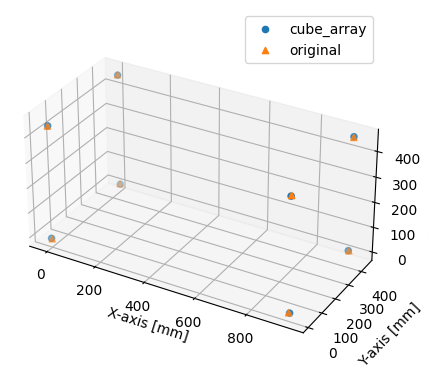

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cube_array[:, 0], cube_array[:, 1], cube_array[:, 2], marker='o', label='cube_array')
ax.scatter(cube_3d[:, 0], cube_3d[:, 1], cube_3d[:, 2], marker='^', label='original')
ax.set_xlabel('X-axis [mm]')
ax.set_ylabel('Y-axis [mm]')
ax.set_zlabel('Z-axis [mm]')
ax.legend()
ax.set_aspect('equal')
plt.show()

In [25]:
data_num = 0

camera_name1 = "2"
camera_name2 = "3"

cam1_dir = f"data/hirasaki_{camera_name1}_{data_num}/"
cam2_dir = f"data/hirasaki_{camera_name2}_{data_num}/"

cam1_position = pd.read_csv(os.path.join(cam1_dir, FileName.position_data), index_col="frame")
cam2_position = pd.read_csv(os.path.join(cam2_dir, FileName.position_data), index_col="frame")

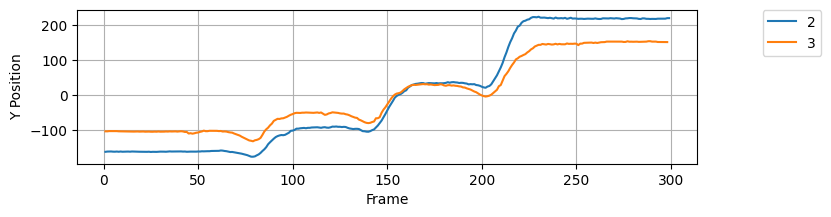

In [26]:
name = "LEFT_ANKLE"

fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(cam1_position.index, cam1_position[f"{name}_y"] - cam1_position[f"{name}_y"].mean(), label=camera_name1)
ax.plot(cam2_position.index, cam2_position[f"{name}_y"] - cam2_position[f"{name}_y"].mean(), label=camera_name2)
ax.grid()
ax.set_xlabel('Frame')
ax.set_ylabel('Y Position')
ax.legend(bbox_to_anchor=(1.2, 1), loc='upper right', borderaxespad=0)
plt.show()

In [27]:
df_camera_sync = pd.read_csv("camera_sync.csv")

toe_off_1 = df_camera_sync["toe_off_2"].iloc[data_num]
toe_off_2 = df_camera_sync["toe_off_3"].iloc[data_num]

delay_1 = toe_off_1 - toe_off_1
delay_2 = toe_off_2 - toe_off_1

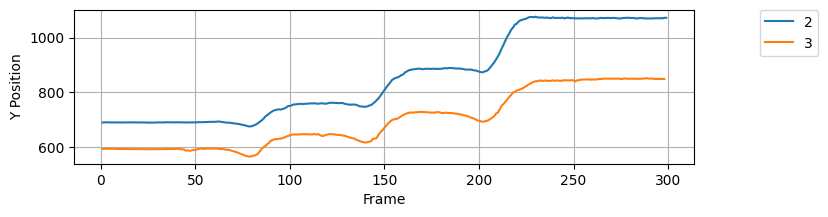

In [28]:
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(cam1_position.index - delay_1, cam1_position[f"{name}_y"], label=camera_name1)
ax.plot(cam2_position.index - delay_2, cam2_position[f"{name}_y"], label=camera_name2)
ax.grid()
ax.set_xlabel('Frame')
ax.set_ylabel('Y Position')
ax.legend(bbox_to_anchor=(1.2, 1), loc='upper right', borderaxespad=0)
plt.show()

In [29]:
cam1_position["ID"] = cam1_position.index - delay_1
cam2_position["ID"] = cam2_position.index - delay_2

In [30]:
cam1_position = cam1_position.loc[cam1_position["ID"] > 0]
cam2_position = cam2_position.loc[cam2_position["ID"] > 0]

In [31]:
cam1_position.set_index("ID", inplace=True, drop=True)
cam2_position.set_index("ID", inplace=True, drop=True)

In [32]:
min_frame = max(cam1_position.index.min(), cam2_position.index.min())
max_frame = min(cam1_position.index.max(), cam2_position.index.max())

print(min_frame, max_frame)

1.0 298.0


In [33]:
frame = min_frame
cam1_pose = cam1_position.loc[frame].values.reshape(-1, 2)
cam2_pose = cam2_position.loc[frame].values.reshape(-1, 2)
pose = np.array([cam1_pose, cam2_pose], dtype=np.float32)
pose_result = pose_recon_2c(cam, P, pose)

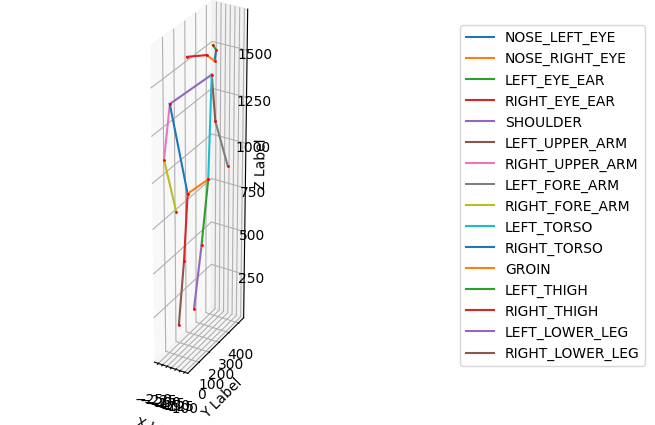

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for key, value in exp_keypoints_connections.items():
    start_idx = value[0]
    end_idx = value[1]
    ax.plot([pose_result[start_idx][0], pose_result[end_idx][0]],
            [pose_result[start_idx][1], pose_result[end_idx][1]],
            [pose_result[start_idx][2], pose_result[end_idx][2]], label=key)
for i in range(len(pose_result)):
    ax.scatter(pose_result[i][0], pose_result[i][1], pose_result[i][2], color='r', s=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
ax.set_aspect('equal')
plt.show()

In [35]:
columns = [f"{kpt}_{xyz}" for kpt in exp_keypoints_list for xyz in ["x", "y", "z"]]
position_df = pd.DataFrame(columns=columns)
position_df.index.name = 'frame'

for frame in range(int(min_frame), int(max_frame) + 1):
    cam1_pose = cam1_position.loc[frame].values.reshape(-1, 2)
    cam2_pose = cam2_position.loc[frame].values.reshape(-1, 2)
    pose = np.array([cam1_pose, cam2_pose], dtype=np.float32)
    pose_result = pose_recon_2c(cam, P, pose)
    position_df.loc[frame] = pose_result.ravel()

position_df

,NOSE_x,NOSE_y,NOSE_z,LEFT_EYE_x,LEFT_EYE_y,LEFT_EYE_z,RIGHT_EYE_x,RIGHT_EYE_y,RIGHT_EYE_z,LEFT_EAR_x,...,LEFT_KNEE_z,RIGHT_KNEE_x,RIGHT_KNEE_y,RIGHT_KNEE_z,LEFT_ANKLE_x,LEFT_ANKLE_y,LEFT_ANKLE_z,RIGHT_ANKLE_x,RIGHT_ANKLE_y,RIGHT_ANKLE_z
frame,,,,,,,,,,,,,,,,,,,,,
1,-94.647580,165.491580,1565.295712,-106.741603,201.447825,1602.457646,-120.225893,136.333574,1600.501186,-157.706695,...,476.440263,-214.637828,85.009901,491.172647,-260.436852,259.317604,98.205244,-250.877920,93.086009,99.610058
2,-94.980658,165.619414,1565.691377,-106.936359,201.461836,1602.786885,-115.584305,136.477717,1599.345847,-157.674744,...,476.182264,-215.071681,85.244637,491.936500,-260.124188,259.093714,96.909056,-255.214550,96.254831,98.760004
3,-98.201776,168.584642,1565.482142,-110.166049,204.442947,1602.588882,-114.814366,136.445626,1600.560332,-156.061919,...,477.864404,-214.465979,85.353570,491.934000,-259.515333,259.037075,95.335280,-254.605659,96.381504,98.889522
4,-97.205711,168.693972,1564.125767,-109.197841,204.571301,1601.239048,-117.838718,139.577925,1600.707149,-155.446634,...,480.681438,-213.544580,85.647241,493.356275,-258.828527,259.397492,94.987286,-253.763752,96.637928,98.573991
5,-95.650463,171.622212,1565.547233,-108.994969,204.685820,1601.076023,-117.532511,139.655049,1600.541991,-154.992155,...,482.270021,-213.011283,85.676816,493.289218,-258.562252,259.472081,96.326984,-253.200038,96.468199,98.295156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,3792.783140,229.008993,1510.904017,3667.984951,265.549078,1549.691189,3867.233522,194.789512,1523.478630,3802.910872,...,389.347486,3798.883208,110.665804,403.823793,3738.647223,321.069368,52.931453,3754.598112,102.795643,72.601495
295,3790.238718,229.129460,1512.104649,3667.723656,265.645922,1552.306340,3866.988189,195.004788,1523.159770,3802.822660,...,389.089160,3801.019026,110.961860,404.161897,3738.486744,321.424025,52.731613,3756.807736,103.465789,74.709110
296,3789.949216,229.512689,1513.957138,3667.416819,265.794350,1554.434664,3868.876989,195.390175,1526.246678,3802.461393,...,389.148259,3800.794695,111.286916,404.378097,3738.235882,321.726186,52.819027,3756.557067,103.452485,73.281160


In [36]:
plot_3d_motion_exp(position_df/1000, output_name="camera23.html")